# Binary Classification of 747 vs A380
The goal is to classify a picture between two classes : an Boing 747 or an Airbus A380

There is a nice script to get images from Google : https://github.com/boxabirds/fastai-helpers/blob/master/training-data-generator.py, it's based on https://github.com/hardikvasa/google-images-download wich use ChromeDriver to automate the process.

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
PATH = "../../datasets/boing_vs_airbus/"
#PATH = "../../datasets/A380_vs_A330/"
## Getting dataset
#!mkdir ../../datasets/boing_vs_airbus
#!pip install google_images_download
#!ls ../../datasets/
#!cd {PATH} && mkdir -p train/747 train/A380 test/747 test/A380  valid/747 valid/A380
#!cd {PATH}/747 && googleimagesdownload --keywords "Boing 747" --limit 1000 --chromedriver /usr/local/bin/chromedriver
#!cd {PATH}/A380 && googleimagesdownload --keywords "Airbus A380" --limit 1000 --chromedriver /usr/local/bin/chromedriver
## Getting models weights
#!cd ./fastai && wget http://files.fast.ai/models/weights.tgz && tar -xvzf weights.tgz
!ls {PATH}

A380_vs_A330  downloads  models  others_A380  tmp  train  valid


In [3]:
print("Setting CUDA devices...")
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="6"
print("Loading Fast.AI modules...")
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from sklearn.metrics import confusion_matrix

sz=299
arch=resnext50
bs=132

def plot_ep_vals(ep_vals):
    plt.ylabel("loss")
    plt.xlabel("epoch")
    epochs = len(ep_vals)#ep_vals.keys()
    #plt.xticks(np.asarray(list(epochs)))
    plt.xticks((list(ep_vals)))
    #print((list(ep_vals)))
    trn_losses = [item[0] for item in list(ep_vals.values())]
    #print(trn_losses)
    val_losses = [item[1] for item in list(ep_vals.values())]
    #print(val_losses)
    plt.plot(list(ep_vals), trn_losses, c='b', label='train')
    plt.plot(list(ep_vals), val_losses, c='r', label='validation')
    plt.legend(loc='upper left')

def plot_the_confusion_matrix():
    log_preds,y = learn.TTA()
    probs = np.mean(np.exp(log_preds),0)
    accuracy_np(probs, y)
    preds = np.argmax(probs, axis=1)
    probs = probs[:,1]
    cm = confusion_matrix(y, preds)
    plot_confusion_matrix(cm, data.classes)
    # precission = VP / (VP + FP)
    precision = cm[0][0]/(cm[0][1]+cm[0][0]);
    print("Precision : ", precision)
    # recall =  = VP / (VP + FN)
    recall = cm[0][0]/(cm[1][0]+cm[0][0]);
    print("Recall : ", recall)
    F1 = 2 * ((precision*recall)/(precision + recall))
    print("F1 : ", F1)
    F2 = 5 * ((precision*recall)/(4*precision + recall))
    print("F2 : ", F2)
    return cm

Setting CUDA devices...
Loading Fast.AI modules...


/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
print("CuDNN optimization is ", torch.backends.cudnn.enabled)

CuDNN optimization is  True


Data augmentation options : https://becominghuman.ai/data-augmentation-using-fastai-aefa88ca03f1

Combien avons nous d'échantillons dans notre base d'entrainement

Environs 500 images pour les deux classes, c'est équilibré.
Regardons maintenant la taille des images.

Il y a beaucoup de petites images, zoomons sur le graph pour être sûr qu'elle ne sont pas trop petites

# Training from sratch
We begin with an empty ResNext50 model.

In [5]:

# Mean
import glob
import PIL
means = np.array([0.0,0.0,0.0])
files = [val for sublist in [[os.path.join(i[0], j) for j in i[2]] for i in os.walk(f'{PATH}train/747')] for val in sublist]
print("Input images number : ", len(files))
deviations = np.array([0.0,0.0,0.0])
#variances = np.array([0,0,0])
variance = np.array([0.0,0.0,0.0])
for image in files:
    #print(image)
    img_stats = PIL.ImageStat.Stat(PIL.Image.open(image), mask=None)
    means += np.array(img_stats.mean)
    variance += np.array(img_stats.var)

stddev = np.sqrt(variance) / len(files)
print("stddev with PIL : ", stddev)

mean = np.array(means) / len(files) / 255
print("Means with PIL : ", mean)
stats = (mean, stddev)

650


/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


stddev with PIL :  [2.17619 2.12457 2.2603 ]
Means with PIL :  [0.54074 0.56913 0.59862]


 81%|████████  | 67/83 [00:14<00:03,  4.58it/s, loss=2.56] 

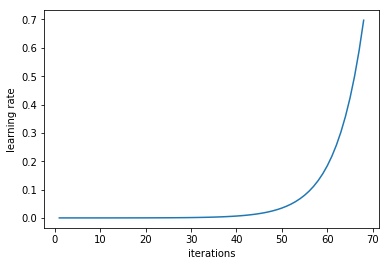

In [6]:
image_size=128
#stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))
tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=16, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5, pretrained=False)
lrf=learn.lr_find()
learn.sched.plot_lr()


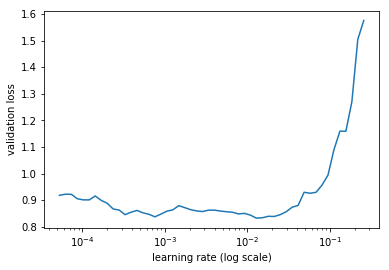

In [7]:
learn.sched.plot()

epoch      trn_loss   val_loss   accuracy                  
    0      0.84364    0.691595   0.532258  
    1      0.777567   0.684944   0.564516                  
    2      0.750015   0.698354   0.519355                  
    3      0.725018   0.683858   0.603226                  
    4      0.734837   0.689183   0.548387                  
    5      0.712774   0.687194   0.56129                   
    6      0.719925   0.697438   0.496774                  
    7      0.720881   0.690347   0.529032                  
    8      0.720666   0.688982   0.548387                  
    9      0.7085     0.688808   0.545161                  
    10     0.712644   0.690845   0.545161                  
    11     0.709748   0.686671   0.577419                  
    12     0.70913    0.68454    0.567742                  
    13     0.705347   0.68767    0.558065                  
    14     0.715448   0.681898   0.564516                  
    15     0.718638   0.688031   0.532258               

array([[155,   0],
       [155,   0]])

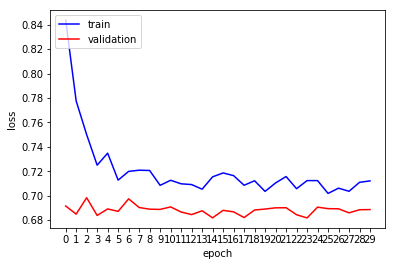

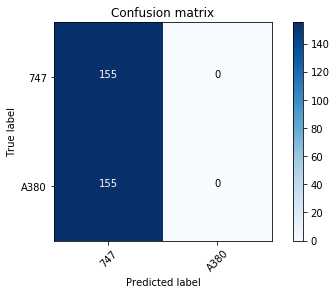

In [8]:
lr=1e-3
image_size=128
batch_size=256
epoch=30
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, image_size), bs=batch_size, num_workers=num_cpus())
vals_s2s, global_results = learn.fit(lr, n_cycle=epoch, get_ep_vals=True)
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5, pretrained=False)
print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
plot_ep_vals(global_results)
plot_the_confusion_matrix()

## Fine tuning

epoch      trn_loss   val_loss   accuracy                
    0      0.933398   0.702816   0.525806  
    1      0.929797   0.715857   0.512903                
    2      0.904497   0.722975   0.519355                
    3      0.886792   0.720126   0.545161                
    4      0.873861   0.706642   0.56129                 
    5      0.851202   0.698557   0.554839                
    6      0.828739   0.68238    0.583871                
    7      0.809107   0.673757   0.6                     
    8      0.790427   0.665278   0.619355                
    9      0.771219   0.654733   0.632258                
    10     0.759733   0.645766   0.641935                
    11     0.74667    0.63583    0.658065                
    12     0.733454   0.626762   0.654839                
    13     0.723164   0.622661   0.651613                
    14     0.710816   0.615089   0.680645                
    15     0.69328    0.605187   0.680645                
    16     0.673561   0.6035

array([[124,  31],
       [ 51, 104]])

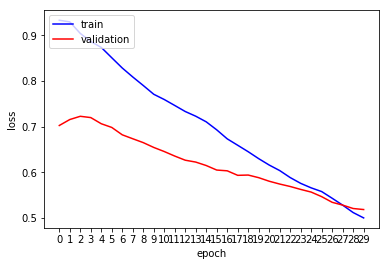

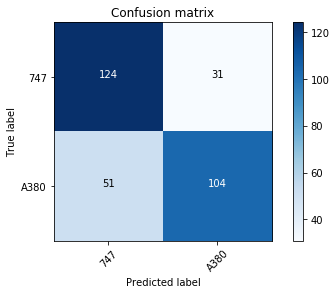

In [9]:
image_size=128
batch_size=150
lr=0.0001
epoch=30
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, image_size), bs=batch_size, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5, pretrained=True)
learn.unfreeze()
vals_s2s, global_results = learn.fit(lr, n_cycle=epoch, get_ep_vals=True)
print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
plot_ep_vals(global_results)
plot_the_confusion_matrix()

## Data augmentation

1322

'train/747/57. boeing-747-200.jpg'

/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


epoch      trn_loss   val_loss   accuracy                
    0      0.906602   0.742865   0.516129  
    1      0.920083   0.732683   0.522581                
    2      0.913299   0.72825    0.53871                 
    3      0.895242   0.717318   0.558065                
    4      0.884297   0.696684   0.6                     
    5      0.865958   0.684715   0.587097                
    6      0.859294   0.672853   0.619355                
    7      0.849468   0.65877    0.625806                
    8      0.840026   0.647303   0.63871                 
    9      0.825257   0.641563   0.654839                
    10     0.815353   0.635623   0.622581                
    11     0.807151   0.634512   0.641935                
    12     0.790693   0.622992   0.66129                 
    13     0.779419   0.603529   0.670968                
    14     0.767387   0.602843   0.683871                
    15     0.751645   0.60198    0.696774                
    16     0.744656   0.5943

array([[115,  40],
       [ 41, 114]])

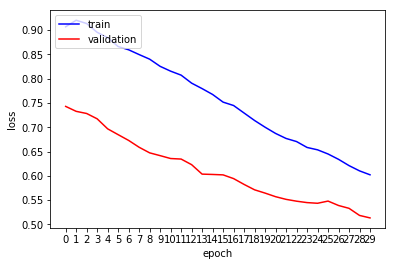

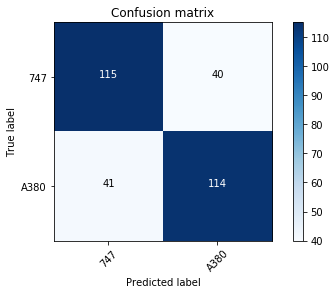

In [10]:
image_size=128
batch_size=150
lr=0.0001
epoch=30
aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO),
        RandomFlip(),
        RandomLighting(0.05, 0.05,tfm_y=TfmType.NO),
        RandomZoom(zoom_max=0.2),
        RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, image_size, aug_tfms=aug_tfms, max_zoom=1.1)

data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=batch_size, num_workers=num_cpus())

#next(iter(data.aug_dl)) Retourne batch_size images de taille sz*sz
len(data.trn_ds.fnames)
# data.trn_ds contient le dataset de test
data.trn_ds.fnames[100]

size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}
row_sz, col_sz = list(zip(*size_d.values()))
row_sz = np.array(row_sz)
col_sz = np.array(col_sz)

learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5, pretrained=True)
learn.unfreeze()
vals_s2s, global_results = learn.fit(lr, n_cycle=epoch, get_ep_vals=True)
print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
plot_ep_vals(global_results)
plot_the_confusion_matrix()

## Multiple size

epoch      trn_loss   val_loss   accuracy                
    0      0.916467   0.736612   0.529032  
After  1  epochs, the accuracy is  52.90 %
Saving to  resnext50_1_300_acc52.90_weights


epoch      trn_loss   val_loss   accuracy                
    0      0.903028   0.729722   0.545161  
    1      0.913      0.751944   0.535484                
    2      0.89973    0.742465   0.548387                
    3      0.894749   0.732978   0.551613                
    4      0.895541   0.728634   0.574194                
    5      0.891853   0.733592   0.570968                
    6      0.887701   0.728799   0.583871                
    7      0.87947    0.718189   0.577419                
    8      0.867613   0.711771   0.612903                
    9      0.862633   0.70748    0.619355                
After  11  epochs, the accuracy is  61.93 %
Saving to  resnext50_11_64_acc61.93_weights


epoch      trn_loss   val_loss   accuracy                
    0      0.830006   0.706856   0.609677  
    1      0.805431   0.703255   0.612903                
    2      0.821817   0.701109   0.609677                
    3      0.822853   0.69151    0.616129                
    4      0.827671   0.689076   0.616129                
    5      0.824461   0.686183   0.616129                
    6      0.824109   0.681936   0.616129                
    7      0.815289   0.678071   0.622581                
    8      0.81743    0.675051   0.616129                
    9      0.819584   0.672381   0.606452                
After  21  epochs, the accuracy is  60.64 %
Saving to  resnext50_21_128_acc60.64_weights


epoch      trn_loss   val_loss   accuracy                
    0      0.829111   0.671529   0.612903  
    1      0.810833   0.66944    0.612903                
    2      0.814432   0.668616   0.609677                
    3      0.812176   0.663564   0.609677                
    4      0.796795   0.662778   0.616129                
    5      0.796066   0.656779   0.612903                
    6      0.782257   0.656074   0.622581                
    7      0.772636   0.653683   0.619355                
    8      0.764948   0.649799   0.632258                
After  30  epochs, the accuracy is  63.22 %
Saving to  resnext50_30_300_acc63.22_weights
[[111  44]                                   
 [ 57  98]]
Precision :  0.7161290322580646
Recall :  0.6607142857142857
F1 :  0.6873065015479876
F2 :  0.6711003627569528


array([[111,  44],
       [ 57,  98]])

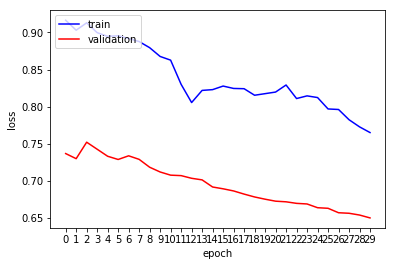

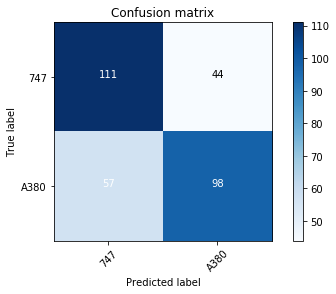

In [11]:
learning_rate = 1e-4
dropout = [0.25,0.5]
global_results = collections.OrderedDict([])
image_size = 128
batch_size = 150
aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO), RandomFlip(), RandomLighting(0.05, 0.05,tfm_y=TfmType.NO), RandomZoom(zoom_max=0.2),RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, image_size, aug_tfms=aug_tfms, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=batch_size, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=dropout, pretrained=True)
learn.unfreeze()
training_loop = [
    [123, 300, 1],
    [512, 64, 10],
    [150, 128, 10],
    [123, 300, 9],
]

for bs, sz, epoch in training_loop:
    lr=np.array([learning_rate/100,learning_rate/10,learning_rate]) # Learning rate plus faible pour les premières couche, pour ré-apprendre un peu si necessaire
    tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=0.5)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=num_cpus())
    vals_s2s, ep_vals_s2s = learn.fit(lr, n_cycle=epoch, get_ep_vals=True)
    if len(global_results) > 0:
        #print(global_results)
        for k, v in ep_vals_s2s.items():
            global_results[len(global_results)] = v
    else:
        global_results = ep_vals_s2s
    print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
    fichier = arch.__name__ + '_' + str(len(global_results)) + "_" + str(sz) + "_acc" + str(vals_s2s[1]*100)[:5] + '_weights'
    print("Saving to ", fichier)
    learn.save(fichier)
plot_ep_vals(global_results)
plot_the_confusion_matrix()

## SGDR - Learning rate anealing

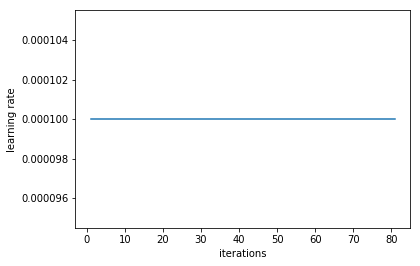

In [12]:
learn.sched.plot_lr()

Hyperparameters : Batch size= 123  Drop out= [0.25, 0.5]  Learning rate= 0.001  Cycle= 1  Images sizes= 300


epoch      trn_loss   val_loss   accuracy                    
    0      0.790855   0.562242   0.706452  
After  1  epochs, the accuracy is  70.64 %
Saving to  resnext50_1_300_acc70.64_weights
Hyperparameters : Batch size= 512  Drop out= [0.25, 0.5]  Learning rate= 0.001  Cycle= 10  Images sizes= 64


epoch      trn_loss   val_loss   accuracy                    
    0      0.547717   0.523554   0.741935  
    1      0.550619   0.453888   0.787097                    
    2      0.58987    0.568931   0.703226                    
    3      0.482421   0.462349   0.777419                    
    4      0.390665   0.405218   0.806452                    
    5      0.450349   0.373661   0.825806                    
    6      0.737087   0.631285   0.658065                    
    7      0.679203   0.611228   0.667742                    
    8      0.63119    0.575619   0.690323                    
    9      0.639813   0.592087   0.696774                    
After  11  epochs, the accuracy is  69.67 %
Saving to  resnext50_11_64_acc69.67_weights
Hyperparameters : Batch size= 150  Drop out= [0.25, 0.5]  Learning rate= 0.001  Cycle= 10  Images sizes= 128


epoch      trn_loss   val_loss   accuracy                    
    0      0.593158   0.55047    0.722581  
    1      0.608466   0.684305   0.609677                    
    2      0.556997   0.556563   0.719355                    
    3      0.5641     0.585594   0.719355                    
    4      0.551289   0.556603   0.722581                    
    5      0.549003   0.569629   0.690323                    
    6      0.478031   0.600032   0.648387                    
    7      0.497725   0.548834   0.709677                    
    8      0.548822   0.51009    0.767742                    
    9      0.524389   0.512671   0.764516                    
After  21  epochs, the accuracy is  76.45 %
Saving to  resnext50_21_128_acc76.45_weights
Hyperparameters : Batch size= 123  Drop out= [0.25, 0.5]  Learning rate= 0.001  Cycle= 10  Images sizes= 300


epoch      trn_loss   val_loss   accuracy                    
    0      0.483848   0.512996   0.732258  
    1      0.434932   0.480356   0.741935                    
    2      0.449417   0.44822    0.803226                    
    3      0.436996   0.5315     0.716129                    
    4      0.57761    0.566336   0.680645                    
    5      0.542596   0.523686   0.712903                    
    6      0.580012   0.598881   0.703226                    
    7      0.533827   0.521553   0.741935                    
    8      0.486061   0.584678   0.709677                    
    9      0.501914   0.647493   0.664516                    
After  31  epochs, the accuracy is  66.45 %
Saving to  resnext50_31_300_acc66.45_weights
[[ 74  81]                                   
 [  8 147]]
Precision :  0.4774193548387097
Recall :  0.9024390243902439
F1 :  0.6244725738396625
F2 :  0.7660455486542443


array([[ 74,  81],
       [  8, 147]])

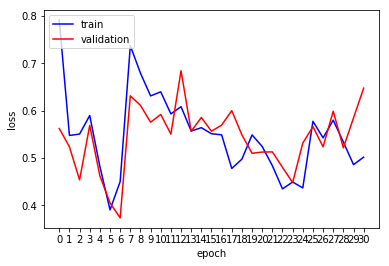

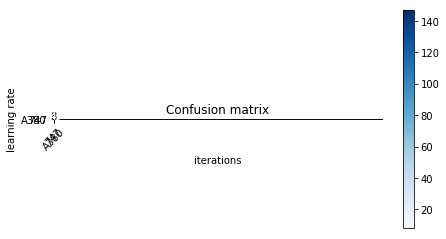

In [13]:
learning_rate = 1e-3
dropout = [0.25,0.5]  # Drop-out plus faible pour les premières couches pour éviter de désapprendre des choses.

aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO),RandomFlip(),RandomLighting(0.05, 0.05,tfm_y=TfmType.NO), RandomZoom(zoom_max=0.2), RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=8, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5)
learn.unfreeze()
learn.ps=dropout
global_results = collections.OrderedDict([])

training_loop = [
    [123, 300, 1],
    [512, 64, 10],
    [150, 128, 10],
    [123, 300, 10],
]
#    [256, 128, 3],
#    [123, 300, 3],
#    [64, 600, 3],
#    [123, 300, 4],
#    [256, 128, 2],
#    [123, 300, 2],
#    [64, 600, 3],
#    [123, 400, 2]
for bs, sz, epoch in training_loop:
    lr=np.array([learning_rate/100,learning_rate/10,learning_rate]) # Learning rate plus faible pour les premières couche, pour ré-apprendre un peu si necessaire
    print("Hyperparameters : Batch size=", bs, " Drop out=", dropout, " Learning rate=", learning_rate, " Cycle=", epoch, " Images sizes=", sz )
    tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=0.5)
    # On recharge les données avec une taille de batch plus importante pour aller plus vite
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=num_cpus())
    vals_s2s, ep_vals_s2s = learn.fit(lr, n_cycle=epoch, cycle_len=1, get_ep_vals=True)
    if len(global_results) > 0:
        for k, v in ep_vals_s2s.items(): global_results[len(global_results)] = v
    else:
        global_results = ep_vals_s2s
    print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
    fichier = arch.__name__ + '_' + str(len(global_results)) + "_" + str(sz) + "_acc" + str(vals_s2s[1]*100)[:5] + '_weights'
    print("Saving to ", fichier)
    learn.save(fichier)
plot_ep_vals(global_results)
plot_the_confusion_matrix()
learn.sched.plot_lr()

In [ ]:
plot_the_confusion_matrix()

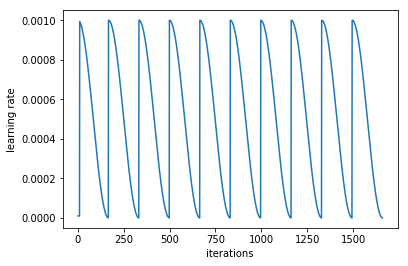

In [14]:
learn.sched.plot_lr()

## Variable cycle length

Hyperparameters : Batch size= 123  Drop out= [0.25, 0.5]  Learning rate= 0.001  Cycle= 3  Images sizes= 300


epoch      trn_loss   val_loss   accuracy                    
    0      0.749025   0.567003   0.7       
    1      0.635471   0.540848   0.706452                    
    2      0.544426   0.565249   0.729032                    
    3      0.502624   0.437529   0.809677                    
    4      0.387353   0.415033   0.825806                    
    5      0.346882   0.367915   0.858065                    
    6      0.342446   0.469917   0.790323                    
After  7  epochs, the accuracy is  79.03 %
Saving to  resnext50_7_300_acc79.03_weights
Hyperparameters : Batch size= 512  Drop out= [0.25, 0.5]  Learning rate= 0.001  Cycle= 4  Images sizes= 64


epoch      trn_loss   val_loss   accuracy                    
    0      0.334174   0.343016   0.86129   
    1      0.32319    0.308685   0.877419                    
    2      0.348015   0.393212   0.835484                    
    3      0.3705     0.320877   0.851613                    
    4      0.291729   0.305744   0.887097                    
    5      0.25189    0.297515   0.893548                    
    6      0.242214   0.315859   0.877419                    
    7      0.437537   0.387281   0.783871                    
    8      0.329508   0.381389   0.816129                    
    9      0.263671   0.397422   0.83871                     
    10     0.459965   0.380766   0.841935                    
    11     0.480796   0.428854   0.790323                    
    12     0.409294   0.402703   0.829032                    
    13     0.433299   0.424266   0.803226                    
    14     0.415861   0.43583    0.803226                    
After  22  epochs, the acc

epoch      trn_loss   val_loss   accuracy                    
    0      0.412676   0.41961    0.796774  
    1      0.382363   0.511911   0.754839                    
    2      0.524554   0.512632   0.725806                    
    3      0.501144   0.40471    0.816129                    
    4      0.375503   0.370271   0.816129                    
    5      0.37066    0.368377   0.825806                    
    6      0.358827   0.367093   0.829032                    
After  29  epochs, the accuracy is  82.90 %
Saving to  resnext50_29_128_acc82.90_weights
Hyperparameters : Batch size= 123  Drop out= [0.25, 0.5]  Learning rate= 0.001  Cycle= 2  Images sizes= 400


epoch      trn_loss   val_loss   accuracy                    
    0      0.410022   0.336723   0.858065  
    1      0.410901   0.389177   0.816129                    
    2      0.345775   0.488307   0.767742                    
After  32  epochs, the accuracy is  76.77 %
Saving to  resnext50_32_400_acc76.77_weights


<Figure size 1120x640 with 0 Axes>

[[101  54]                                   
 [  8 147]]
Precision :  0.6516129032258065
Recall :  0.926605504587156
F1 :  0.7651515151515152
F2 :  0.8544839255499155


array([[101,  54],
       [  8, 147]])

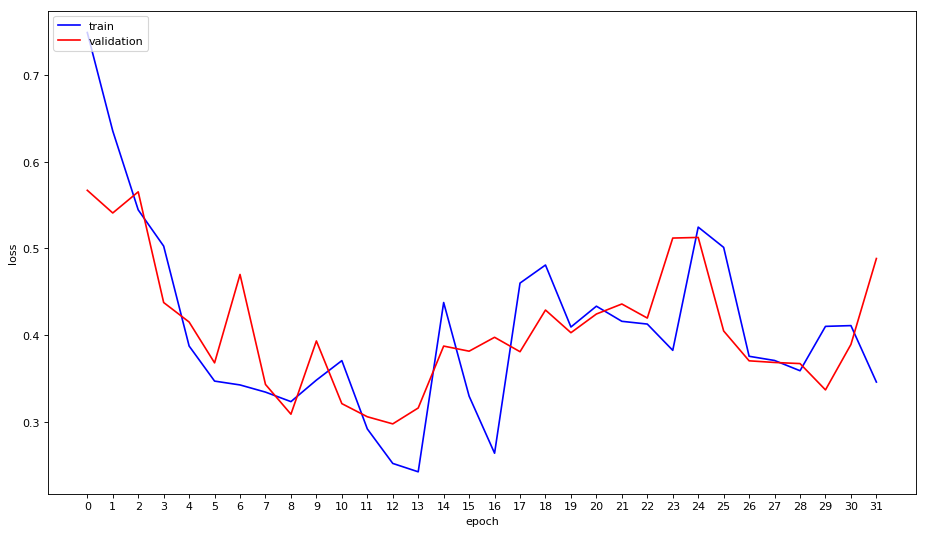

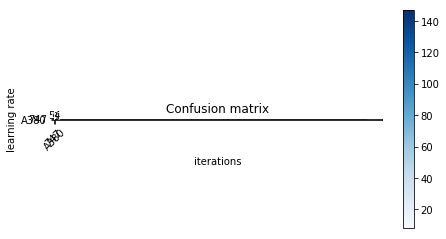

In [15]:
##### XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXx #####
# Fonctionne bien
#print(sz)
learning_rate = 1e-3
dropout = [0.25,0.5]  # Drop-out plus faible pour les premières couches pour éviter de désapprendre des choses.

aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO),RandomFlip(),RandomLighting(0.05, 0.05,tfm_y=TfmType.NO), RandomZoom(zoom_max=0.2), RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=8, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5)
learn.unfreeze()
learn.ps=dropout
global_results = collections.OrderedDict([])

training_loop = [
    [123, 300, 3],
    [512, 64, 4],
    [256, 128, 3],
#     [64, 600, 3],
#     [123, 300, 6],
#     [256, 128, 2],
#     [123, 300, 2],
#     [64, 600, 3],
    [123, 400, 2]
]
for bs, sz, cycle in training_loop:
    print("Hyperparameters : Batch size=", bs, " Drop out=", dropout, " Learning rate=", learning_rate, " Cycle=", cycle, " Images sizes=", sz )
    tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=0.5)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=num_cpus())
    lr=np.array([learning_rate/10,learning_rate/5,learning_rate]) # Learning rate plus faible pour les premières couche, pour ré-apprendre un peu si necessaire
    vals_s2s, ep_vals_s2s = learn.fit(lr, cycle, cycle_len=1, cycle_mult=2, get_ep_vals=True)
    if len(global_results) > 0:
        for k, v in ep_vals_s2s.items(): global_results[len(global_results)] = v
    else:
        global_results = ep_vals_s2s
    print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
    fichier = arch.__name__ + '_' + str(len(global_results)) + "_" + str(sz) + "_acc" + str(vals_s2s[1]*100)[:5] + '_weights'
    print("Saving to ", fichier)
    learn.save(fichier)
plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plot_ep_vals(global_results)
plot_the_confusion_matrix()
learn.sched.plot_lr()

[[108  47]                                   
 [  7 148]]
Precision :  0.6967741935483871
Recall :  0.9391304347826087
F1 :  0.8
F2 :  0.878048780487805


array([[108,  47],
       [  7, 148]])

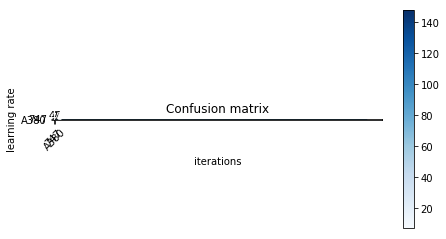

In [16]:
plot_the_confusion_matrix()

[[104  51]                                   
 [  8 147]]
Precision :  0.6709677419354839
Recall :  0.9285714285714286
F1 :  0.7790262172284644
F2 :  0.8623548922056385


array([[104,  51],
       [  8, 147]])

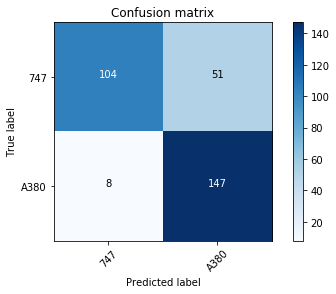

In [25]:
plot_the_confusion_matrix()

C'est bon, les plus petites font plus de 200 pixels.
On note que la majorité on une taille importante, il sera bon de faire des entrainement du modèle avec des tailles supérieures.

_"How many images should we use as a validation set? [01:26:28] Using 20% is fine unless the dataset is small — then 20% is not enough. If you train the same model multiple times and you are getting very different validation set results, then your validation set is too small. If the validation set is smaller than a thousand, it is hard to interpret how well you are doing. If you care about the third decimal place of accuracy and you only have a thousand things in your validation set, a single image changes the accuracy. If you care about the difference between 0.01 and 0.02, you want that to represent 10 or 20 rows. Normally 20% seems to work fine."_
=> Nous avons environs 100 images de validation par classes, ça devrait donc aller.

Faisons un test d'entrainement avec une petite taille de batch pour estimer la valeur du learning rate.

1e-2 semble une bonne valeur

In [17]:
loadmodel=False
#loadmodel=True
if loadmodel==True:
    data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, 64), bs=123, num_workers=num_cpus())
    data = get_data(64, 64) 
    learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5, pretrained=False)
    learn.load("resnext50_32_400_acc95.01_weights")
    learn.freeze()
    vals_s2s, global_results = learn.fit(0.00001, n_cycle=1, get_ep_vals=True)
    plot_ep_vals(global_results)
    print("Model chargé")

Object `get_data` not found.


SGDR : Earlier we said 3 is the number of epochs, but it is actually *cycles*. So if cycle_len=2 , it will do 3 cycles where each cycle is 2 epochs (i.e. 6 epochs). Then why did it 7? It is because of cycle_mult :
    cycle_mult=2 : this multiplies the length of the cycle after each cycle (1 epoch + 2 epochs + 4 epochs = 7 epochs).

# Prediction et visualisation

[[105  50]                                   
 [  5 150]]
Precision :  0.6774193548387096
Recall :  0.9545454545454546
F1 :  0.7924528301886793
F2 :  0.8823529411764707


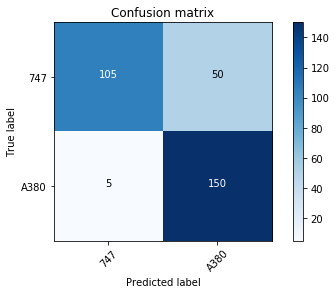

In [19]:
cm = plot_the_confusion_matrix()

In [20]:
?plot_confusion_matrix

## Precision and Recall
Précision et rappel en français : https://fr.wikipedia.org/wiki/Pr%C3%A9cision_et_rappel
_La précision est le nombre de documents pertinents retrouvés rapporté au nombre de documents total proposé par le moteur de recherche pour une requête donnée. _ Autrement dit quelle proportion d'identifications positives était effectivement correcte ?

_Le rappel est défini par le nombre de documents pertinents retrouvés au regard du nombre de documents pertinents que possède la base de données._ Autrement dit quelle proportion de résultats positifs réels a été identifiée correctement ?

In [21]:
# precission = VP / (VP + FP)
precision = cm[0][0]/(cm[0][1]+cm[0][0]);
print("Precision : ", precision)
# recall =  = VP / (VP + FN)
recall = cm[0][0]/(cm[1][0]+cm[0][0]);
print("recall : ", recall)
F1 = 2 * ((precision*recall)/(precision + recall))
print("F1 : ", F1)
F2 = 5 * ((precision*recall)/(4*precision + recall))
print("F2 : ", F2)

Precision :  0.6774193548387096
recall :  0.9545454545454546
F1 :  0.7924528301886793
F2 :  0.8823529411764707


(array([155.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 155.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

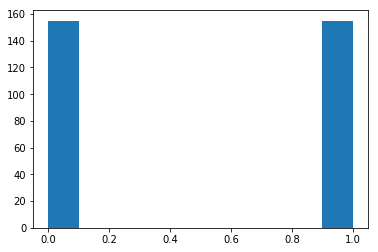

In [22]:
# This is the label for a val data
plt.hist(data.val_y)

In [23]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape  # = (nombre de prediction , nombre de classe)
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

from math import ceil
nb_images = 10

# Récupère aléatoirement des prédictions
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), nb_images), replace=False)

# Récupère les prédictions correctes
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

# Affiche les images
def plots(ims, figsize=(20,10), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=12)
        plt.imshow(ims[i])

# Charge l'image
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

# Affiche des images avec un titre
def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [(str(probs[x]) + "\n" + str(data.val_ds.fnames[x][10:][:20])) for x in idxs]
    print(title)
    nb_lignes = ceil(len(idxs) / 3)
    return plots(imgs, rows=nb_lignes, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

# Recupère les prédiction triées
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:nb_images]] # Les nb_images premiers éléments

# Recupère les prédictions les plus justes
def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

['747', 'A380']

(310, 2)

Most incorrect 747


ValueError: num must be 1 <= num <= 8, not 9

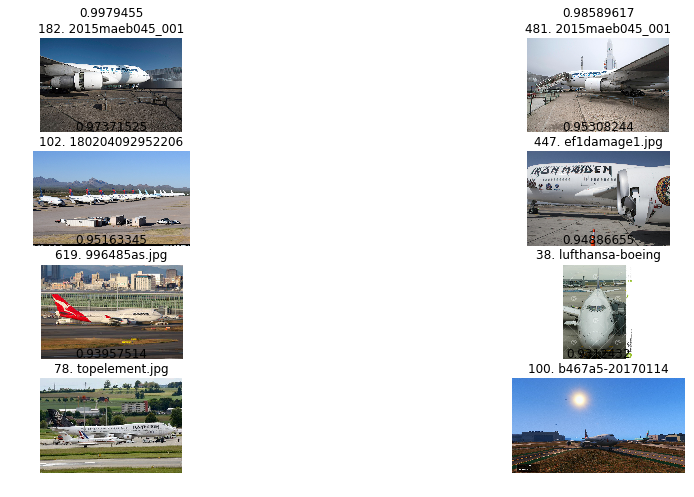

In [24]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect " + data.classes[0])

Most incorrect A380


ValueError: num must be 1 <= num <= 4, not 5

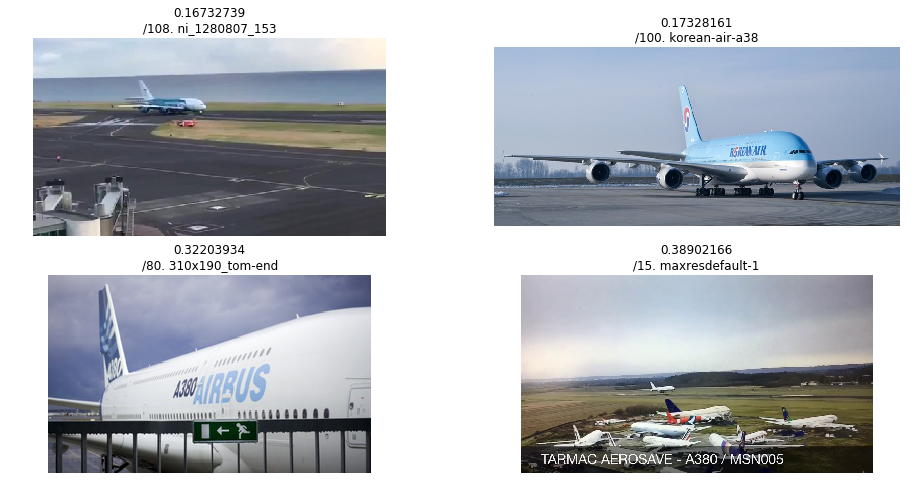

In [26]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect " + data.classes[1])

In [ ]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:nb_images]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [ ]:
plot_val_with_title(most_by_correct(1, True), "Most correct " + data.classes[1])

In [ ]:
plot_val_with_title(most_by_correct(0, True), "Most correct " + data.classes[0])
# 1. A few correct labels at random
#plot_val_with_title(rand_by_correct(True), "Correctly classified")
# 2. A few incorrect labels at random
#plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [ ]:
aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO),
        RandomFlip(),
        RandomLighting(0.05, 0.05,tfm_y=TfmType.NO),
        RandomZoom(zoom_max=0.2),
        RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=1.1)
# Taille de batch faible pour trouver le bon learning rate
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=8, num_workers=num_cpus())
def get_augs():
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=2, num_workers=2)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

ims = np.stack([get_augs() for i in range(8)])
plots(ims, rows=2)

#next(iter(data.aug_dl)) Retourne batch_size images de taille sz*sz
len(data.trn_ds.fnames)
# data.trn_ds contient le dataset de test
data.trn_ds.fnames[100]

size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}
row_sz, col_sz = list(zip(*size_d.values()))
row_sz = np.array(row_sz)
col_sz = np.array(col_sz)

In [ ]:
plt.hist(data.trn_y)

In [ ]:
plt.hist(row_sz);
plt.hist(col_sz);
plt.hist(row_sz[row_sz < 1000])